In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os

# Preparing Metadata/Labels

In [3]:
all_files = glob.glob("/mnt/b/Google_Drive/PhD/Project with Janet/Kohler_Corrected/*.HDR")

file_names = pd.concat({n: pd.DataFrame([{FN.split("/")[-1][13:-4]:FN for FN in all_files if FN.split("/")[-1][4] == str(n) }]).T for n in [1,2]})

file_names.reset_index(inplace = True)
file_names.columns = ["TMA", "Core", "envi_loc"]

In [4]:
all_files = glob.glob("/mnt/b/Google_Drive/PhD/Project with Janet/Label_Images/TMA*/*.png")

label_names = pd.concat({n: pd.DataFrame([{FN.split("/")[-1][8:-4]:FN for FN in all_files if FN.split("/")[-2][-1] == str(n) }]).T for n in [1,2]})

label_names.reset_index(inplace = True)
label_names.columns = ["TMA", "Core", "Annotation_loc"]

In [5]:
file_locations = label_names.merge(file_names, left_on = ["TMA", "Core"], right_on = ["TMA", "Core"])

In [6]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

In [7]:
metadata = metadata.dropna(subset = ["TMA"]).query("TMA in [1,2]").merge(file_locations
                                                              , left_on = ["TMA", "TMA site"]
                                                              , right_on = ["TMA", "Core"])

In [8]:
metadata.shape

(117, 19)

In [9]:
metadata.head()

,TMA,TMA site,gender,Patient nu,Corrected Site AJCC/UICC,Pathogical Stage,T stage,N stage,ECS,diff,advancing front type,Overall Death,survival (months),recurrence,radiotherapy,Diagnosis Age,Core,Annotation_loc,envi_loc
0,1.0,G6,m,3143,FOM,pT4N0,4,0,no,mod,islands,yes,111.0,yes,yes,58.0,G6,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
1,1.0,C10,m,3169,FOM,pT3N1M0,3,1,no,poor,non cohesive,yes,17.0,NaN,yes,63.0,C10,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
2,1.0,D9,m,3237,other,pT4aN2aMx,4a,2a,yes,mod well,non-cohesive,yes,2.0,yes,yes,59.0,D9,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
3,1.0,F4,f,3241,FOM,pT2N2bMx,2,2b,yes,NaN,non-coherent,yes,81.0,no,yes,75.0,F4,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
4,1.0,C11,m,3248,FOM,pT2N2bM0,2,2b,yes,mod,non-cohesive,yes,55.0,no,yes,67.0,C11,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...


# Import some data

In [10]:
import spectral
from imageio import imread

from UNETprocess import *

from sklearn.preprocessing import Normalizer, RobustScaler

In [26]:
sample = metadata.query("TMA == 2").sample(5)
fn = np.array(sample["envi_loc"])

Import images and do a bit of preprocessing to drop the paraffin region and trim unwanted wavenumbers.

In [29]:
images = {name: image_import(spectral.envi.open(name), RobustScaler("l2")) for name in sample["envi_loc"]}

wn = pd.DataFrame(np.array(spectral.envi.open(sample["envi_loc"].iloc[0]).metadata["wn"], dtype = np.float))
starti, endi, psi, pei = [np.argmin(np.abs(i - wn).values) for i in [1000, 1800, 1340, 1490]]

# Disregard unwanted wavenumbers                          
wn = wn.iloc[starti:endi]
wn = wn.drop(np.arange(psi, pei)).values

Header parameter names converted to lower case.


/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/spectral/io/envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/spectral/io/envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/spectral/io/envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/spectral/io/envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.
Header parameter names converted to lower case.


/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/spectral/io/envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [261]:
Annotations = {name.split("/")[-1]: imread(name)[:,:,:-1]/255 for name in sample["Annotation_loc"]}

In [204]:
Annotations.keys()

dict_keys(['TMA_1.1_B6.png', 'TMA_1.4_G8.png', 'TMA_1.1_D2.png', 'TMA_1.1_D5.png', 'TMA_1.1_D6.png'])

In [275]:
colours = pd.read_excel("/mnt/b/Git_Projects/Biospec_Analysis/UNET/Colours.xlsx")
colours["RGB"] = colours.apply(lambda row: np.array([row.R, row.G, row.B])/255, axis = 1)
colours.set_index("Tissue", inplace = True)

In [31]:
np.argmin(np.abs(1652 - wn))

130

In [32]:
tab = pd.concat({key.split("/")[-1][13:-4]: pd.DataFrame(value.reshape(-1, value.shape[-1])) for key, value in images.items()})
tab.columns = wn

Text(0.5, 0, 'Wavenumber $(cm^{-1})$')

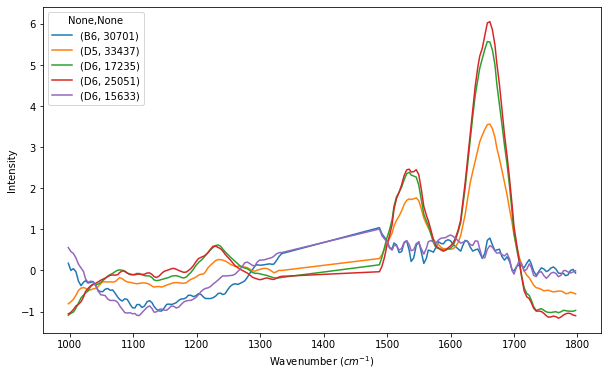

In [185]:
ax = tab.sample(5).T.plot(figsize = (10,6))
ax.set_ylabel("Intensity")
ax.set_xlabel("Wavenumber $(cm^{-1})$")

Text(0.5, 0, 'Wavenumber $(cm^{-1})$')

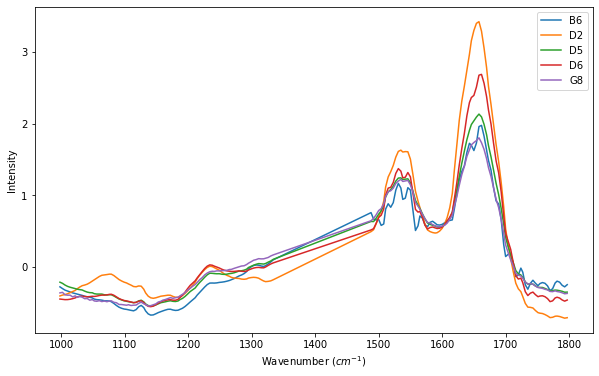

In [186]:
ax = tab.groupby(level = 0).mean().T.plot(figsize = (10,6))
ax.set_ylabel("Intensity")
ax.set_xlabel("Wavenumber $(cm^{-1})$")

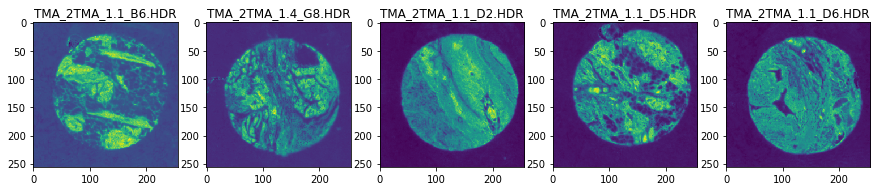

In [187]:
fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

for im, title, ax in zip(images.values(), images.keys(), axes.flatten()):
    
    ax.set_title(title.split("/")[-1])
    ax.imshow(im[:,:,130].squeeze())

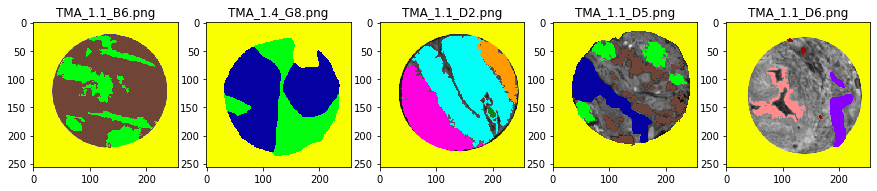

In [262]:
fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

for im, title, ax in zip(Annotations.values(), Annotations.keys(), axes.flatten()):
    
    ax.set_title(title.split("/")[-1])
    ax.imshow(im)

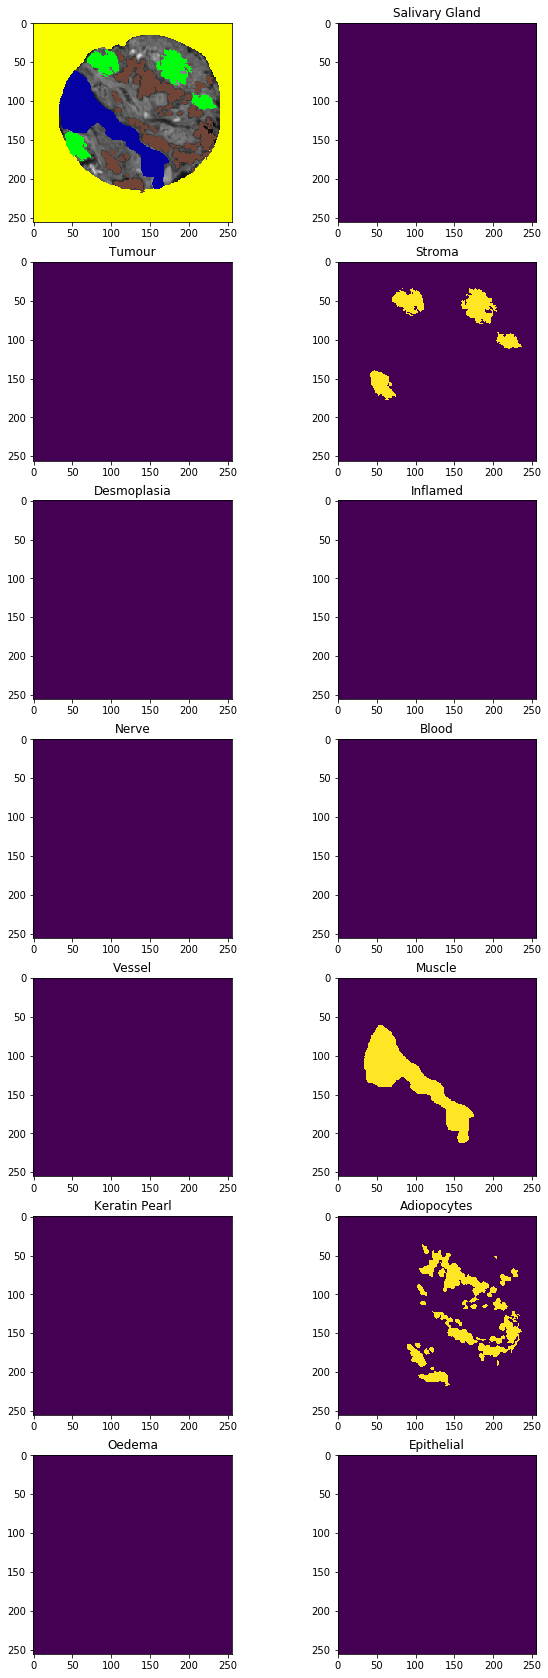

In [289]:
image = Annotations[list(Annotations.keys())[3]]

fig, axes = plt.subplots(7, 2, figsize = (1,30))
axes = axes.flatten()

axes[0].imshow(image)

for i, (name, row) in enumerate(colours.iterrows(), start = 1):
    
    axes[i].imshow(np.all(image == row["RGB"], axis = 2))
    axes[i].set_title(name)

# Image_Generator

In [46]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [52]:
x_train = np.stack(images.values())
y_train = np.array(list(images.keys()))

mask_x_train = np.stack(Annotations.values())/255
mask_y_train = np.array(list(Annotations.keys()))

imgen_args = dict(
              rotation_range = 90,
              featurewise_center = True,
              samplewise_center = True,
              featurewise_std_normalization = True,
              samplewise_std_normalization = True,
              width_shift_range = (0.3,0.3),
              height_shift_range = (0.3,0.3),
              zoom_range = (0.2, 0.9),
              horizontal_flip = True,
              vertical_flip = True,
              zca_whitening = False
)

imgen = ImageDataGenerator(**imgen_args)
maskgen = ImageDataGenerator(**imgen_args)

Print a few examples from the imagedatagenerator

In [48]:
seed = np.random.randint(100)

/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (5, 256, 256, 169) (169 channels).
  ' channels).')
/home/conor/miniconda3/envs/NN/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5, 256, 256, 169) (169 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


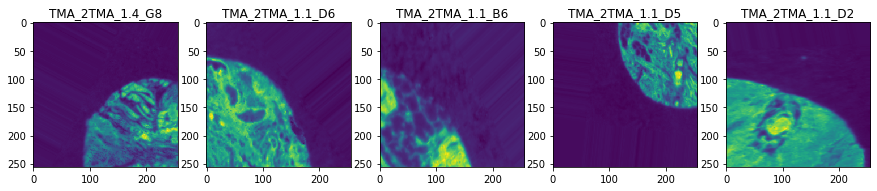

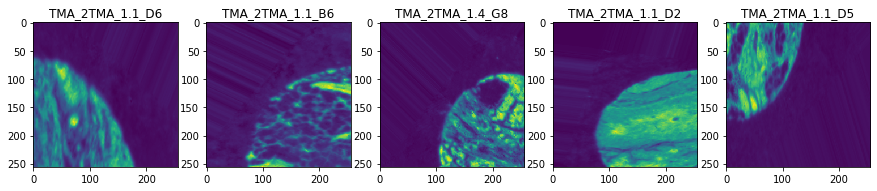

In [49]:
i = 0

imgen.fit(x_train, seed = seed)

for ims, titles in imgen.flow(x_train, y_train, batch_size = 5):

    fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

    for im, title, ax in zip(ims, titles, axes.flatten()):

        name = title.split("/")[-1][:-4]

        ax.set_title(f"{name}")
        ax.imshow(im[:,:,130].squeeze())
    
    if i >= 1:
        break
        
    else:
        i +=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

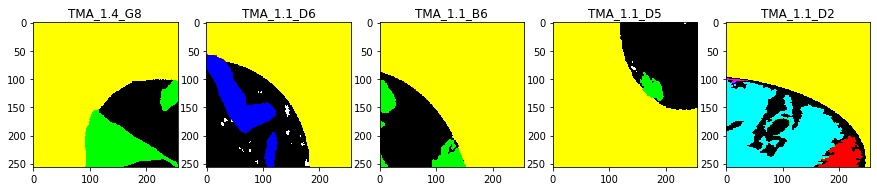

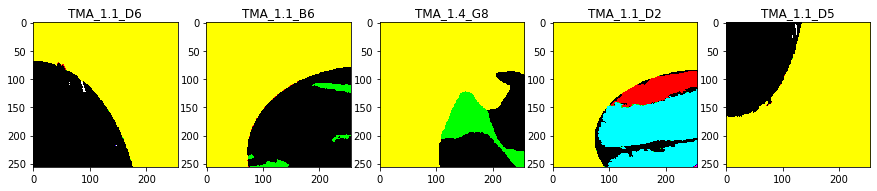

In [53]:
i = 0

maskgen.fit(mask_x_train, seed = seed)

for ims, titles in maskgen.flow(mask_x_train, mask_y_train, batch_size = 5):

    fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

    for im, title, ax in zip(ims, titles, axes.flatten()):

        name = title.split("/")[-1][:-4]

        ax.set_title(f"{name}")
        ax.imshow(im.squeeze())
    
    if i >= 1:
        break
        
    else:
        i +=1

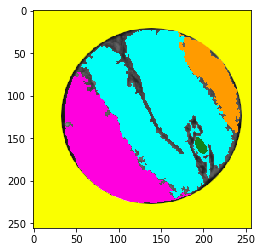

In [127]:
plt.imshow(Annotations.popitem()[1])

## U-Net

In [164]:
from UNET import *

In [169]:
Unet = UNet(n_classes = 2, input_size = im.shape)

In [173]:
Unet.make_unet()

In [174]:
from keras.utils import plot_model

In [175]:
plot_model(Unet.model)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.